# Generate Samples

In [18]:
from sklearn.datasets import make_blobs
# generate 2d classification dataset
X, y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=1)
# summarize
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

(200, 2) (200,)
[[-10.8278844   -4.83392615]
 [-11.18003063  -4.61910307]
 [-10.55520723  -3.0141798 ]
 [ -1.42706535   5.08904128]
 [ -8.16299488  -3.38896569]]
[1 1 1 0 1]


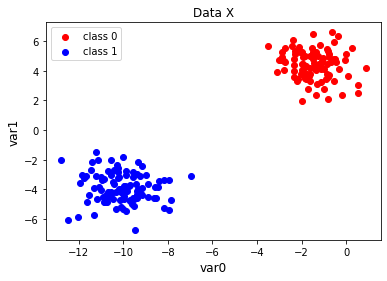

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(X[y == 0, 0], X[y == 0, 1], c = 'red', label='class 0')
ax.scatter(X[y == 1, 0], X[y == 1, 1], c = 'blue', label='class 1')
ax.set_title('Data X')
ax.set_xlabel('var0', fontsize=12)
ax.set_ylabel('var1', fontsize=12)
ax.legend()

# Naive Bayes Classifier 

In [35]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import numpy as np
import pandas as pd

class NaiveBayesClassifier:
    def __init__(self, smoothing_alpha = 0.01, kde_on = False, bandwidth = 2):
        self.__classes_priory = []
        self._features_info = {}
        self.__smoothing_alpha = smoothing_alpha
        self.__kde_on = kde_on
        self.__bandwidth = bandwidth

    def fit(self, X, y):
        self.__data_len = len(y)
        self.__classes = np.sort(np.unique(y))
        self.__num_classes = len(self.__classes)
        self.__categorical_threshold = round(np.sqrt(self.__data_len * 0.5)) # empirical formula
        
        self.__set_classes_priory(y)
        
        for feat in X.columns:
            self.__set_feature_info(feat, X[feat].values, np.squeeze(y.values))
        
    
    def __set_classes_priory(self, y):
        for cl in self.__classes:
            self.__classes_priory.append(np.sum(y.values == cl) / self.__data_len)
            
    
    def __set_feature_info(self, feature_name, feature_col, target_col):
        self._features_info[feature_name] = {}
        feat_type = ''
        feat_unique_count = len(np.unique(feature_col))
        
        if feat_unique_count < self.__categorical_threshold :
            feat_type = 'discrete'
            self._features_info[feature_name]['categories_proba'] = {}
            self._features_info[feature_name]['num_categories'] = feat_unique_count
            
            for category in np.sort(np.unique(feature_col)):
                self._features_info[feature_name]['categories_proba'][category] = []
                
                for cl in self.__classes:
                    self._features_info[feature_name]['categories_proba'][category].append(
                        self.__get_category_proba_for_class(feature_col[target_col == cl], category, feat_unique_count))
        else:
            feat_type = 'continuous'
            self._features_info[feature_name]['dist'] = []
            
            for cl in self.__classes:
                self._features_info[feature_name]['dist'].append(
                    self.__get_continuous_feature_parameters(feature_col[target_col == cl]))
            
        self._features_info[feature_name]['type'] = feat_type
        
    
    def __get_category_proba_for_class(self, class_feature_col, category, feat_unique_count):
        numerator = np.sum(class_feature_col == category) + self.__smoothing_alpha
        #---------  ----------------------------------------------------------
        denominator = class_feature_col.shape[0] + feat_unique_count * self.__smoothing_alpha
        
        smoothed_proba = numerator/denominator
        return smoothed_proba
        

    def __get_continuous_feature_parameters(self, class_feature_col):
        if self.__kde_on:
            dist = KernelDensity(bandwidth=self.__bandwidth, kernel='gaussian')
            dist.fit(class_feature_col.reshape(len(class_feature_col), 1))
        else:
            mu = np.mean(class_feature_col)
            sigma = np.std(class_feature_col)
            dist = norm(mu, sigma)
        return dist
        
    
    def predict(self, data):
        return data.apply(lambda row: self.__get_single_prediction(row, 'class'), axis = 1).to_numpy()

    
    def predict_proba(self, data, normalize = True):
        predictions = np.matrix(data.apply(lambda row: self.__get_single_prediction(row, 'proba'), axis = 1).tolist())
        
        if normalize:
            return np.apply_along_axis(self.normalize_proba, 1, predictions)
        
        return predictions
    
    
    def normalize_proba(self, pred):
        pred_sum = np.sum(pred)
        
        for i in range(len(pred)):
            pred[i] /= pred_sum
        
        return pred
    
    
    def predict_log(self, data):
        return np.matrix(data.apply(lambda row: self.__get_single_prediction(row, 'log'), axis = 1).tolist())
        
    
    def __get_single_prediction(self, example, pred_type = 'proba'):
        results = []
        for i in range(len(self.__classes)):
            if pred_type == 'log':
                results.append(np.log(self.__classes_priory[i]))
            else:
                results.append(self.__classes_priory[i])
            
            for key, value in self._features_info.items():
                feature_proba = 0
                
                if value['type'] == 'discrete':
                    feature_proba = value['categories_proba'][example[key]][i]
                elif value['type'] == 'continuous':
                    if self.__kde_on:
                        feature_proba = np.exp(value['dist'][i].score_samples(example[key].reshape(1, -1))[0])
                    else:
                        feature_proba = value['dist'][i].pdf(example[key])
                
                if pred_type == 'log':
                    results[i] += np.log(feature_proba)
                else:
                    results[i] *= feature_proba
        
        if pred_type == 'class':
            return np.argmax(results)
        
        return results
    
    
    def summary(self):
        print('General information :')
        classes_priory = ",  ".join([str(self.__classes[i]) + " : " + str(round(self.__classes_priory[i], 4)) + "%" for i in range(len(self.__classes_priory))])
        settings = pd.DataFrame({'attribute' : ['data_len', 'classes_priory', 'smoothing_alpha', 'kde_on', 'bandwidth', 'categorical_threshold'],
                                 'value' : [self.__data_len, classes_priory, self.__smoothing_alpha, self.__kde_on, self.__bandwidth, self.__categorical_threshold]})
        display(settings)
        
        print('\nInformation about features :')
        
        
        

In [21]:
np.random.seed(1)
data_X = pd.DataFrame(np.append(X, np.random.randint(5, size=(200,1 )), axis = 1), columns=['var1', 'var2', 'var3'])
data_y = pd.DataFrame(y, columns=['training_class'])

In [22]:
data_y[data_y.training_class == 0] = 'first'
data_y[data_y.training_class == 1] = 'second'

In [23]:
data_y

,training_class
0,second
1,second
2,second
3,first
4,second
...,...
195,second
196,first
197,first
198,second


In [36]:
classifier = NaiveBayesClassifier(kde_on=True)

In [37]:
classifier.fit(data_X, data_y)

In [38]:
classifier._features_info

{'var1': {'dist': [KernelDensity(algorithm='auto', atol=0, bandwidth=2, breadth_first=True,
                 kernel='gaussian', leaf_size=40, metric='euclidean',
                 metric_params=None, rtol=0),
   KernelDensity(algorithm='auto', atol=0, bandwidth=2, breadth_first=True,
                 kernel='gaussian', leaf_size=40, metric='euclidean',
                 metric_params=None, rtol=0)],
  'type': 'continuous'},
 'var2': {'dist': [KernelDensity(algorithm='auto', atol=0, bandwidth=2, breadth_first=True,
                 kernel='gaussian', leaf_size=40, metric='euclidean',
                 metric_params=None, rtol=0),
   KernelDensity(algorithm='auto', atol=0, bandwidth=2, breadth_first=True,
                 kernel='gaussian', leaf_size=40, metric='euclidean',
                 metric_params=None, rtol=0)],
  'type': 'continuous'},
 'var3': {'categories_proba': {0.0: [0.21999000499750127, 0.21999000499750127],
   1.0: [0.2, 0.21999000499750127],
   2.0: [0.13003498250874562, 0.

In [39]:
print(y[:10])
print(classifier.predict_proba(data_X.iloc[:10, :]))

[1 1 1 0 1 1 0 1 0 1]
[[2.42952777e-08 9.99999976e-01]
 [1.53509688e-08 9.99999985e-01]
 [6.19156201e-07 9.99999381e-01]
 [9.99999761e-01 2.39175113e-07]
 [3.89193211e-05 9.99961081e-01]
 [1.13476733e-06 9.99998865e-01]
 [9.99999859e-01 1.40681690e-07]
 [4.44840307e-08 9.99999956e-01]
 [9.99999654e-01 3.46065518e-07]
 [1.48916247e-07 9.99999851e-01]]


In [40]:
classifier.summary()

,attribute,value
0,data_len,200
1,classes_priory,"first : 0.5%, second : 0.5%"
2,smoothing_alpha,0.01
3,kde_on,True
4,bandwidth,2
5,categorical_threshold,10


In [ ]:
# if feat_type == 'discrete':
#     rv = multinomial(self.__data_len, [0.3, 0.2, 0.5])
#     rv.pmf([1, 3, 4])
# elif feat_type == 'binomial':
#     rv = binom(self.__data_len, feat.count(1))
#     rv.pmf(18)
# elif feat_type == 'continuous': 
#     mu = np.mean(feat)
#     sigma = np.std(feat)
#     dist = np.norm(mu, sigma)
#     return dist

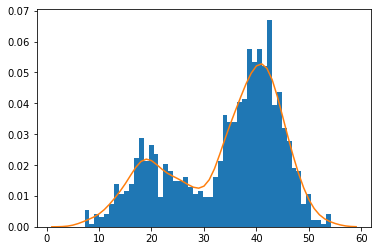

In [235]:
# example of kernel density estimation for a bimodal data sample
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
# generate a sample
sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)
sample = hstack((sample1, sample2))
# fit density
model = KernelDensity(bandwidth=2, kernel='gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)
# sample probabilities for a range of outcomes
values = asarray([value for value in range(1, 60)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = exp(probabilities)
# plot the histogram and pdf
pyplot.hist(sample, bins=50, density=True)
pyplot.plot(values[:], probabilities)
pyplot.show()

In [236]:
probabilities

array([4.35547799e-06, 2.04689177e-05, 7.60725101e-05, 2.24811372e-04,
       5.33196827e-04, 1.03126592e-03, 1.67218456e-03, 2.37928088e-03,
       3.16509198e-03, 4.17473410e-03, 5.55992724e-03, 7.31733033e-03,
       9.31604054e-03, 1.14966534e-02, 1.39379517e-02, 1.66322546e-02,
       1.92403788e-02, 2.11666757e-02, 2.19186368e-02, 2.14355764e-02,
       2.01353861e-02, 1.86436509e-02, 1.73986161e-02, 1.64500728e-02,
       1.55935814e-02, 1.46529230e-02, 1.36516101e-02, 1.28148443e-02,
       1.25060041e-02, 1.31736140e-02, 1.52347874e-02, 1.88037314e-02,
       2.34618586e-02, 2.84461783e-02, 3.31996704e-02, 3.76772724e-02,
       4.20507684e-02, 4.62283221e-02, 4.97658802e-02, 5.21173300e-02,
       5.27810137e-02, 5.13248163e-02, 4.76175572e-02, 4.21136060e-02,
       3.56935011e-02, 2.91604738e-02, 2.29793397e-02, 1.74034486e-02,
       1.26311857e-02, 8.79489639e-03, 5.91321587e-03, 3.89927172e-03,
       2.57414843e-03, 1.69844762e-03, 1.06950748e-03, 6.00094140e-04,
      

Mean=50.076, Standard Deviation=5.050


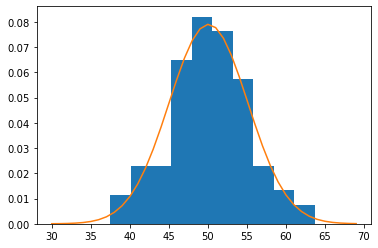

In [276]:
# example of parametric probability density estimation
from matplotlib import pyplot
from numpy.random import normal
from numpy import mean
from numpy import std
from scipy.stats import norm
# generate a sample
sample = normal(loc=50, scale=5, size=200)
# calculate parameters
sample_mean = mean(sample)
sample_std = std(sample)
print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))
# define the distribution
dist = norm(sample_mean, sample_std)
# sample probabilities for a range of outcomes
values = [value for value in range(30, 70)]
probabilities = [dist.pdf(value) for value in values]
# plot the histogram and pdf
pyplot.hist(sample, bins=10, density=True)
pyplot.plot(values, probabilities)
pyplot.show()

In [277]:
probabilities 

[2.9219733450516426e-05,
 6.295974272644956e-05,
 0.00013044245989375509,
 0.0002598629452161861,
 0.0004977818680079085,
 0.0009168602206364859,
 0.0016238149247847873,
 0.002765280986845759,
 0.004528051389483149,
 0.007129396477744461,
 0.010793530623720288,
 0.015712439900868454,
 0.021993435387215304,
 0.02960137294096033,
 0.038308926125790226,
 0.047671349050594024,
 0.057040621262567794,
 0.0656266737004576,
 0.07260154765303554,
 0.07722905230106288,
 0.0789923206928551,
 0.07768879426051935,
 0.07346850965170092,
 0.06680568470757961,
 0.05841104146051709,
 0.04910727331409315,
 0.039697762767017315,
 0.030857133841569684,
 0.023062929800967913,
 0.016574586809222264,
 0.011453554449875777,
 0.007610395021581166,
 0.004862319080067694,
 0.002987095113122787,
 0.0017645094483338714,
 0.0010022320014270185,
 0.0005473711252465337,
 0.0002874516744139682,
 0.0001451500341320772,
 7.047560008491216e-05]